In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import RobustScaler, FunctionTransformer, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
# Load dataset
X_train = pd.read_csv(os.path.join(os.getcwd(), "data", "X_train.csv"))
X_test = pd.read_csv(os.path.join(os.getcwd(), "data", "X_test.csv"))
y_train = pd.read_csv(os.path.join(os.getcwd(), "data", "y_train.csv"))
y_test = pd.read_csv(os.path.join(os.getcwd(), "data", "y_test.csv"))

In [4]:
# Apply OneHotEncoder to categorical variable
numerical_features = ["age", "balance", "duration", "campaign", "pdays", "previous","last_contact_day"]
categorical_features = [col for col in X_train.columns if col not in numerical_features]
binary_features = ["default","housing","loan"]
not_binary_categorical = [col for col in categorical_features if col not in binary_features]

le = LabelEncoder()
for c in binary_features:
    le.fit(X_train[c])
    X_train[c] = le.transform(X_train[c])
    X_test[c] = le.transform(X_test[c])

enc = OneHotEncoder()
encoded_train = pd.DataFrame(enc.fit_transform(X_train[not_binary_categorical]).toarray(), columns=enc.get_feature_names_out())
encoded_test = pd.DataFrame(enc.transform(X_test[not_binary_categorical]).toarray(), columns=enc.get_feature_names_out())

X_train_enc = pd.concat([X_train[numerical_features],X_train[binary_features],encoded_train], axis=1)
X_test_enc = pd.concat([X_test[numerical_features],X_test[binary_features], encoded_test], axis=1)

In [5]:
# Apply trasformation:
# - Log trasformation: goal is to reduce skewness and have distributions close to normal
# - Scaling: goal is to be robust to outliers

def log_transform(x):
    # Since some features have negative values, a traslation is applied
    return np.log(x+1-x.min())

vars = ["duration", "campaign", "pdays", "previous"] # variable to which log trasformation is applied
log_transform=FunctionTransformer(log_transform)
log_transform.fit(X_train[vars])
X_train_enc[vars] = log_transform.transform(X_train_enc[vars])
X_test_enc[vars] = log_transform.transform(X_test_enc[vars])

rbst=RobustScaler()
rbst.fit(X_train_enc[numerical_features])
X_train_enc[numerical_features] = rbst.transform(X_train_enc[numerical_features])
X_test_enc[numerical_features] = rbst.transform(X_test_enc[numerical_features])

# Histogram
fig = px.box(X_train_enc[numerical_features].melt(), facet_col='variable').update_xaxes(matches=None).update_yaxes(matches=None)
fig.show()

In [6]:
# Check imbalance in taget variable
print(y_train.value_counts() / len(y_train))

# Balancing with Undersampling
rus = RandomUnderSampler(random_state=0)
X_train_us, y_train_us = rus.fit_resample(X_train_enc, y_train)

print(y_train_us.value_counts() / len(y_train_us))

# Check train size
print(X_train_us.shape)

y
0    0.926384
1    0.073616
dtype: float64
y
0    0.5
1    0.5
dtype: float64
(4250, 36)


Accuracy: 0.80 - Precision: 0.80 - Recall: 0.24 - F1 Score: 0.37


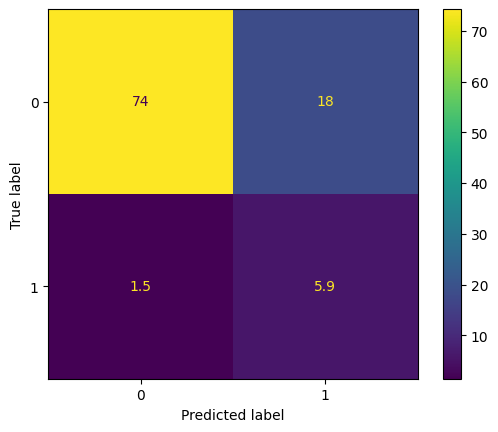

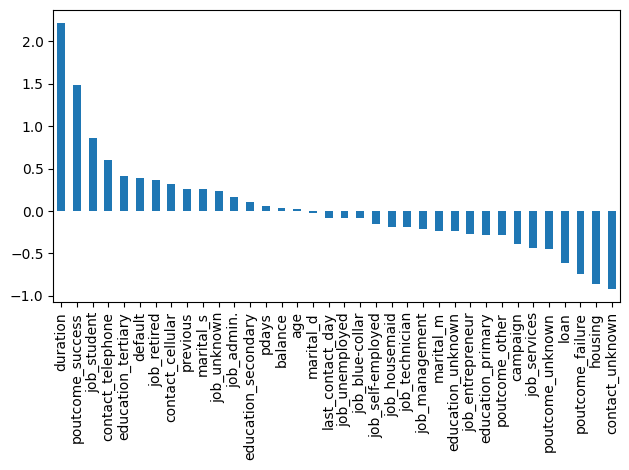

In [7]:
# Define the model
model = LogisticRegressionCV(cv=5,max_iter=1000,random_state=0)

# Fit the classifier
model.fit(X_train_us, y_train_us.values.ravel())

# Make predictions
predictions = model.predict(X_test_enc)

# Calculate metrics
accuracy = accuracy_score(predictions, y_test.values.ravel())
precision = precision_score(predictions, y_test.values.ravel())
recall = recall_score(predictions, y_test.values.ravel())
f1score = f1_score(predictions, y_test.values.ravel())

cm = 100 * confusion_matrix(y_test.values.ravel(), predictions, labels=model.classes_) / len(y_test.values.ravel())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

print(f"Accuracy: {accuracy:.2f} - Precision: {precision:.2f} - Recall: {recall:.2f} - F1 Score: {f1score:.2f}")
disp.plot()
plt.show()

importances = pd.Series(model.coef_[0], index=model.feature_names_in_).sort_values(ascending=False)
fig, ax = plt.subplots()
importances.plot.bar()
fig.tight_layout()

In [8]:
# Recall is low: try with oversampling instead of undersampling
# Apply OneHotEncoder to categorical variable

X_train = pd.read_csv(os.path.join(os.getcwd(), "data", "X_train.csv"))
X_test = pd.read_csv(os.path.join(os.getcwd(), "data", "X_test.csv"))
y_train = pd.read_csv(os.path.join(os.getcwd(), "data", "y_train.csv"))
y_test = pd.read_csv(os.path.join(os.getcwd(), "data", "y_test.csv"))

numerical_features = ["age", "balance", "duration", "campaign", "pdays", "previous","last_contact_day"]
categorical_features_index = [list(X_train.columns).index(col) for col in categorical_features]
binary_features = ["default","housing","loan"]
not_binary_categorical = [col for col in categorical_features if col not in binary_features]

le = LabelEncoder()
for c in binary_features:
    le.fit(X_train[c])
    X_train[c] = le.transform(X_train[c])
    X_test[c] = le.transform(X_test[c])

smote_nc = SMOTENC(categorical_features=categorical_features_index, random_state=0, sampling_strategy=0.40)
X_train_os, y_train_os = smote_nc.fit_resample(X_train, y_train)

# Check imbalance in taget variable
print(y_train.value_counts() / len(y_train))

print(y_train_os.value_counts() / len(y_train_os))

# Check train size
print(X_train_os.shape)

y
0    0.926384
1    0.073616
dtype: float64
y
0    0.714293
1    0.285707
dtype: float64
(37437, 15)


In [9]:
enc = OneHotEncoder()
encoded_train = pd.DataFrame(enc.fit_transform(X_train_os[not_binary_categorical]).toarray(), columns=enc.get_feature_names_out())
encoded_test = pd.DataFrame(enc.transform(X_test[not_binary_categorical]).toarray(), columns=enc.get_feature_names_out())

X_train_enc = pd.concat([X_train_os[numerical_features],X_train_os[binary_features],encoded_train], axis=1)
X_test_enc = pd.concat([X_test[numerical_features],X_test[binary_features], encoded_test], axis=1)

In [10]:
# Apply trasformation:
# - Log trasformation: goal is to reduce skewness and have distributions close to normal
# - Scaling: goal is to be robust to outliers

def log_transform(x):
    # Since some features have negative values, a traslation is applied
    return np.log(x+1-x.min())

vars = ["duration", "campaign", "pdays", "previous"] # variable to which log trasformation is applied
log_transform=FunctionTransformer(log_transform)
log_transform.fit(X_train[vars])
X_train_enc[vars] = log_transform.transform(X_train_enc[vars])
X_test_enc[vars] = log_transform.transform(X_test_enc[vars])

rbst=RobustScaler()
rbst.fit(X_train_enc[numerical_features])
X_train_enc[numerical_features] = rbst.transform(X_train_enc[numerical_features])
X_test_enc[numerical_features] = rbst.transform(X_test_enc[numerical_features])

In [11]:
# Define the model
model = LogisticRegressionCV(cv=5,max_iter=1000,random_state=0)

# Fit the classifier
model.fit(X_train_enc, y_train_os.values.ravel())

# Make predictions
predictions = model.predict(X_test_enc)


Accuracy: 0.89 - Precision: 0.56 - Recall: 0.36 - F1 Score: 0.44


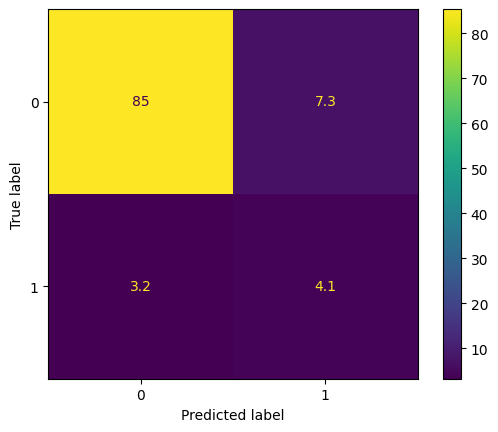

In [12]:

# Calculate metrics sampling_strategy=0.4
accuracy = accuracy_score(predictions, y_test.values.ravel())
precision = precision_score(predictions, y_test.values.ravel())
recall = recall_score(predictions, y_test.values.ravel())
f1score = f1_score(predictions, y_test.values.ravel())

cm = 100 * confusion_matrix(y_test.values.ravel(), predictions, labels=model.classes_) / len(y_test.values.ravel())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

print(f"Accuracy: {accuracy:.2f} - Precision: {precision:.2f} - Recall: {recall:.2f} - F1 Score: {f1score:.2f}")
disp.plot()
plt.show()

# Plot 6 more important features (3 positive - 3 negative)
importances = pd.Series(model.coef_[0], index=model.feature_names_in_).sort_values(ascending=False)
importances_to_plot = pd.concat([importances[:3],importances[-3:]])
imp_df = pd.DataFrame(importances_to_plot).reset_index()
imp_df = pd.melt(imp_df, id_vars=['index'], value_vars=imp_df.columns[1:])
fig = px.bar(imp_df, x='index', y='value', width=800, height=600)
fig.update_traces(textposition='inside')
fig.data[-1].text = np.round(imp_df['value'],3)
fig.show()